<a href="https://colab.research.google.com/github/lastinm/ml_hw_notebooks/blob/main/%D0%A3%D1%80%D0%A4%D0%A3_%D0%9C%D0%9E%D0%9C%D0%9E_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование продаж магазина на основе временных рядов

# Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates#Date Parser

import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

# Установка фиксированного значения
np.random.seed(42)

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)

# Загрузка датасета и подготовка данных

Основной датасет представляет собой продажи различных категорий товаров в одном из магазинов. Состав полей в файле train.csv:

* store_nbr — идентификатор магазина;
* family — категория товаров;
* sales — общий объем продаж для категории товаров в магазине на заданную дату (возможно указание дробных значений);
* onpromotion — количество товаров, участвующих в акциях на определенную дату.

Загрузим датасет. Сразу преобразуем к типу DateTime содержимое поля 'date' и проиндексируем датафрейм по этому полю. Так же исключим из загрузки поле 'id'.

In [84]:
url='https://drive.google.com/file/d/1Q5gkD3X5VUdYPtvznm4Zj115VD_A5Anx/view?usp=sharing'
DF = pd.read_csv('https://drive.usercontent.google.com/download?id={}&export=download&authuser=0&confirm=t'.format(url.split('/')[-2]),
            sep=',',
            index_col='date',
            parse_dates=True,
            usecols=lambda column: column != 'id',
            low_memory=False)
print(DF.head(5))
print("="*80)
print(DF.info())

            store_nbr      family  sales  onpromotion
date                                                 
2013-01-01          1  AUTOMOTIVE    0.0            0
2013-01-01          1   BABY CARE    0.0            0
2013-01-01          1      BEAUTY    0.0            0
2013-01-01          1   BEVERAGES    0.0            0
2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   store_nbr    int64  
 1   family       object 
 2   sales        float64
 3   onpromotion  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 114.5+ MB
None


Выбрем один магазин и пять категорий товаров.

In [85]:
store_nbr = 1  # например, магазин 1
categories = ['BEAUTY', 'CELEBRATION', 'CLEANING', 'SEAFOOD', 'HARDWARE']  # выбранные категории

# Фильтруем DataFrame
df_filtered = DF[(DF['store_nbr'] == store_nbr) & (DF['family'].isin(categories))]

# Проверяем результат
print(df_filtered.head())
print("="*80)
print(df_filtered.info())

            store_nbr       family  sales  onpromotion
date                                                  
2013-01-01          1       BEAUTY    0.0            0
2013-01-01          1  CELEBRATION    0.0            0
2013-01-01          1     CLEANING    0.0            0
2013-01-01          1     HARDWARE    0.0            0
2013-01-01          1      SEAFOOD    0.0            0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8420 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    8420 non-null   int64  
 1   family       8420 non-null   object 
 2   sales        8420 non-null   float64
 3   onpromotion  8420 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 328.9+ KB
None


Удалим пропуски и дубликаты данных.

In [86]:
# Сначала удалим строки с пропущенными значениями
df_cleaned = df_filtered.dropna()

# Затем удалим дубликаты
df_cleaned = df_cleaned.drop_duplicates()

# Проверяем результаты
print("Размер оригинального DataFrame:", df_filtered.shape)
print("Размер очищенного DataFrame:", df_cleaned.shape)

Размер оригинального DataFrame: (8420, 4)
Размер очищенного DataFrame: (3110, 4)


## Удаление выбросов

Удаление выбросов из данных может быть выполнено разными способами, в зависимости от данных и целей. Несколько распространенных методов для идентификации и удаления выбросов:

1. Использование метода межквартильного размаха (IQR)

Этот метод широко используется для определения выбросов. Выбросы - это значения, которые находятся ниже первого квартиля минус 1.5 * IQR или выше третьего квартиля плюс 1.5 * IQR.
2.  Использование стандартного отклонения

Другой распространённый метод заключается в использовании стандартного отклонения. Выбросы определяются как значения, которые находятся за пределами определенного числа стандартных отклонений от среднего.

3. Метод Z-оценки

Z-оценка показывает, насколько далеко значение находится от среднего в стандартных отклонениях. Значения Z-оценки больше 3 или меньше -3 могут считаться выбросами.

Выбор метода удаления выбросов зависит от данных и специфики задачи. Методы IQR и Z-оценки подходят для нормальных распределений, тогда как стандартное отклонение может применяться для значений, которые могут не следовать нормальному распределению. Проведем предварительный анализ данных, чтобы выбрать наиболее подходящий метод.

Теперь мы можем визуализировать данные по продажам для каждой категории товаров.

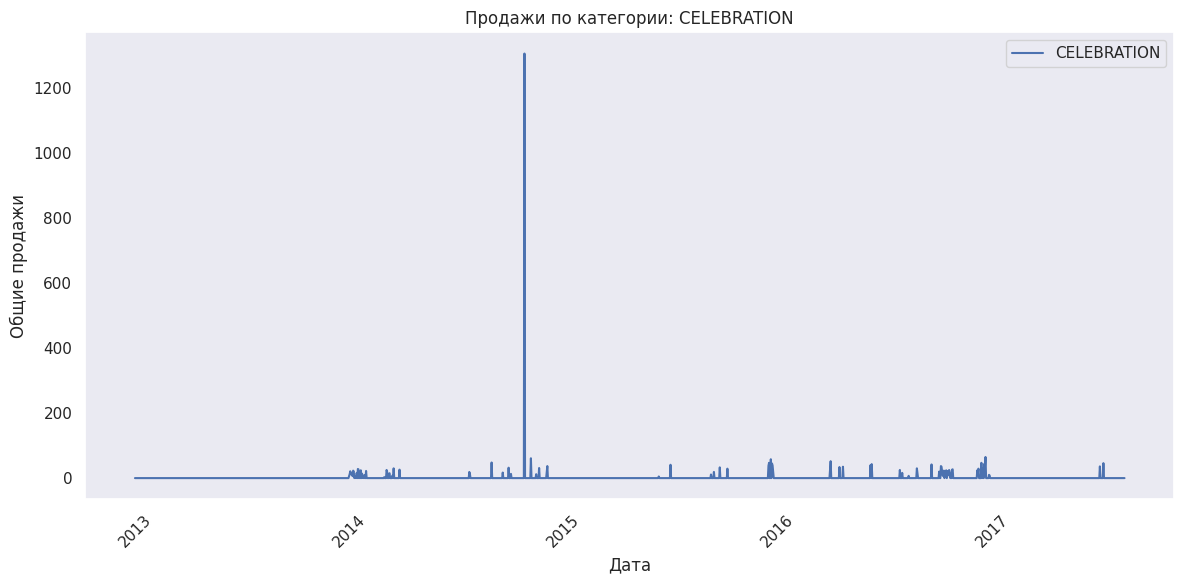

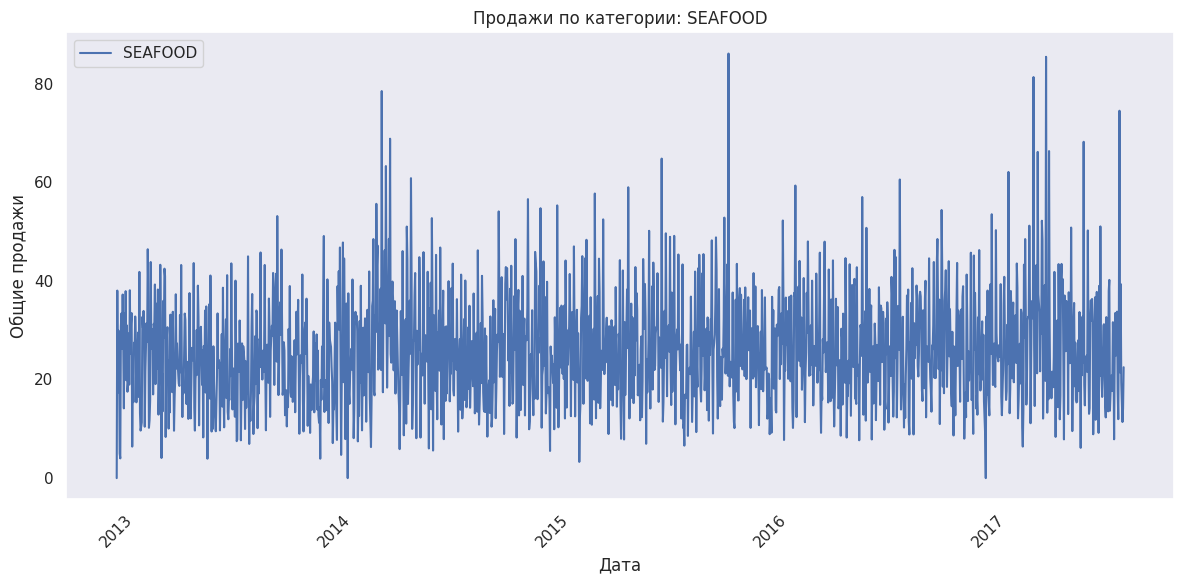

In [79]:
# Сгруппируем данные по дате и категории family, суммируя продажи
sales_by_family = df_cleaned.groupby([df_cleaned.index, 'family'])['sales'].sum().unstack().fillna(0)

# Получаем список уникальных категорий
categories = sales_by_family.columns

# Создаем отдельный график для каждой категории
for category in categories:
    plt.figure(figsize=(12, 6))
    plt.plot(sales_by_family.index, sales_by_family[category], label=category)
    plt.title(f'Продажи по категории: {category}')
    plt.xlabel('Дата')
    plt.ylabel('Общие продажи')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

На полученных графиках мы видим нормальное распределение для двух категорий - CLEANING и SEAFOOD. Для удаления выбросов применим к ним метод Z-оценки. Остальные категории почистим методом исследования стандартного отклонения.

In [ ]:
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    return df[z_scores < threshold]

In [89]:
# Получаем статистику для каждой группы
stats_summary = df_cleaned.groupby('family')['sales'].describe()

print(stats_summary)

              count        mean         std  min      25%      50%      75%  \
family                                                                        
BEAUTY         27.0    6.000000    3.452981  0.0    3.000    6.000    9.000   
CELEBRATION    92.0   37.706522  134.457276  0.0   12.750   22.000   34.000   
CLEANING     1322.0  644.070348  227.241028  0.0  554.000  683.000  787.000   
HARDWARE       12.0    5.666667    3.915780  0.0    2.750    5.500    8.250   
SEAFOOD      1657.0   26.055692   10.988000  0.0   18.064   25.228   32.599   

                  max  
family                 
BEAUTY         12.000  
CELEBRATION  1306.000  
CLEANING     1659.000  
HARDWARE       13.000  
SEAFOOD        86.106  


In [100]:
# Выберем данные категории CLEANING и SEAFOOD
categories = ['SEAFOOD']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием Z-оценки
df_SEAFOOD = remove_outliers_zscore(df_norm, 'sales')

In [101]:
# Выберем данные категории CLEANING и SEAFOOD
categories = ['CLEANING']  # выбранные категории

# Фильтруем DataFrame
df_norm = df_cleaned[df_cleaned['family'].isin(categories)]

# Удаляем выбросы в столбце 'sales' с использованием Z-оценки
df_CLEANING = remove_outliers_zscore(df_norm, 'sales')

In [102]:
union_df = pd.concat([df_SEAFOOD, df_CLEANING])

In [103]:
# Получаем статистику для каждой группы
stats_summary = union_df.groupby('family')['sales'].describe()

print(stats_summary)

           count        mean         std  min      25%      50%      75%  \
family                                                                     
CLEANING  1318.0  641.683612  223.287474  0.0  553.250  682.000  785.000   
SEAFOOD   1642.0   25.656483   10.173976  0.0   17.996   25.159   32.485   

               max  
family              
CLEANING  1284.000  
SEAFOOD     58.986  


Провести исследование данных: проверить дубликаты, пропуски, визуализировать временные ряды.

Очистить данные: заполнить пропуски, устранить дубликаты и выбросы.

Также доступны метаданные о праздничных днях в файле holidays_events.csv:

Содержит информацию о праздниках и событиях.
Включены дополнительные дни, связанные с праздниками (например, канун Рождества).

In [47]:
holiday_data = pd.read_csv('https://lms.skillfactory.ru/asset-v1:Skillfactory+URFUML2023+SEP2023+type@asset+block@holidays_events.csv',
                          sep=',',
                          index_col='date',
                          parse_dates=True)
print('holiday_data shape: {}'.format(holiday_data.shape))
holiday_data

holiday_data shape: (350, 5)


,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [48]:
def add_holiday_features(pd_all, holidays_data):

    # Объединяем данные о продажах с данными о праздничных днях
    merged_data = pd_all.merge(holidays_data, left_on='date', right_on='date', how='left')

    return merged_data

pd_upd = add_holiday_features(pd_all, holiday_data)
pd_upd

,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred
date,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BABY CARE,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEAUTY,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BEVERAGES,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False
2013-01-01,1,BOOKS,0.000,0,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False
2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier


#r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

In [ ]:
try:
    import sktime
except:
#     !pip install sktime --user
#     !pip install pmdarima
#     !pip install statsmodels
#     !pip install prophet
    !pip install --upgrade sktime[all_extras]
import sktime

  Using cached sktime-0.34.0-py3-none-any.whl.metadata (34 kB)
  Using cached scikit_base-0.11.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached autots-0.6.15-py3-none-any.whl.metadata (10 kB)
  Using cached skpro-2.7.0-py3-none-any.whl.metadata (16 kB)
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached hmmlearn-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached keras-self-attention-0.51.0.tar.gz (11 kB)
  Preparing metadata (setup.py) ... done
  Using cached pyod-2.0.2.tar.gz (165 kB)
  Preparing metadata (setup.py) ... done
  Using cached stumpy-1.13.0-py3-none-any.whl.metadata (28 kB)
  Using cached tslearn-0.6.3-py3-none-any.whl.metadata (14 kB)
  Using cached pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached pyts-0.13.0-py3-none-any.whl.metadata (10 kB)
  Using cached statsforecast-1.7.8-cp310-cp310-manylinu

In [ ]:
import dask.dataframe as dd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Проанализируем данные и сформируем из них однопеременный ряд

In [ ]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out

df_hrly = extract_country(df_all, country_code='LT', year_min=2016, year_max=2019)
df_hrly

,load_actual_entsoe_transparency,load_forecast_entsoe_transparency,solar_generation_actual,wind_onshore_generation_actual
utc_timestamp,,,,
2016-01-01 00:00:00+00:00,1094.00,1039.0,0.0,153.00
2016-01-01 01:00:00+00:00,1059.00,1003.0,0.0,138.00
2016-01-01 02:00:00+00:00,1034.00,980.0,0.0,126.00
2016-01-01 03:00:00+00:00,1029.00,981.0,0.0,126.00
2016-01-01 04:00:00+00:00,1050.00,971.0,0.0,131.00
...,...,...,...,...
2019-12-31 19:00:00+00:00,1332.26,1290.0,0.0,412.61
2019-12-31 20:00:00+00:00,1260.15,1222.0,0.0,326.54
2019-12-31 21:00:00+00:00,1191.67,1176.0,0.0,232.77


Нам понадобится только одна колонка, поэтому выделим необходимую. Кроме того приведем колонки к более интерпретируемому виду: зададим понятные названия колонкам, а поле дата сделаем индексным.

In [ ]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    df = df.resample('D').sum(min_count=24)
    df = df.rename_axis('Date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df

cols_map = {'load_actual_entsoe_transparency' : 'Consumption' }   # Потребление
 #           'wind_onshore_generation_actual' : 'Wind',           # Генерация
 #           'solar_generation_actual' : 'Solar'}
df_daily = transform_dataframe(df_hrly, cols_map)

# Compute wind + solar generation
#df_daily['Wind+Solar'] = df_daily[['Wind', 'Solar']].sum(axis=1, skipna=False)
df_daily.to_csv('lt_data.csv')
df_daily.head()

,Consumption
Date,
2016-01-01,28.077
2016-01-02,30.331
2016-01-03,32.060
2016-01-04,36.561
2016-01-05,37.965


В этой таблице мы получили в столбце Consumption общее потребление электроэнергии. С этими данными будем работать дальше.

# Проанализируем сформированный набор данных

Загрузим сохраненные данные таким образом, чтобы даты стали индексами.

In [ ]:
path_ts = 'lt_data.csv'

df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2016-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1452 non-null   float64
dtypes: float64(1)
memory usage: 22.8 KB


Посмотрим сколько у нас NaN значений. Для этого можно использовать или метод isnull или isna.

In [ ]:
df.isna().sum()

,0
Consumption,9


Имеем 9 пропущеных значений. Для этого в Pandas есть несколько инструментов, в том числе ffill, bfill для заполнения пропусков соотвественно следющими или предыдущими значениями. Заполним следующими значениями:

In [ ]:
# Заполнение пропущенных значений предыдущими значениями
df.fillna(method='ffill', inplace=True)
df.isna().sum()

,0
Consumption,0


В ходе анализа этого набора данных в учебном примере было установлено, что ряд потребления энергии имеет как минимум 2 составляющие (быструю, с периодом неделя и медленную с периодом 1 год). Для упрощения анализа и без значительных потерь значимости удалим быструю составляющую при помощи перегрупперовки данных.

In [ ]:
y = df.Consumption.asfreq('7d')
# y.index = pd.PeriodIndex(y.index) # pd.to_datetime(y.index)
y.head()

,Consumption
Date,
2016-01-01,28.077
2016-01-08,39.105
2016-01-15,37.036
2016-01-22,36.968
2016-01-29,32.230


# Визуализация временного ряда

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


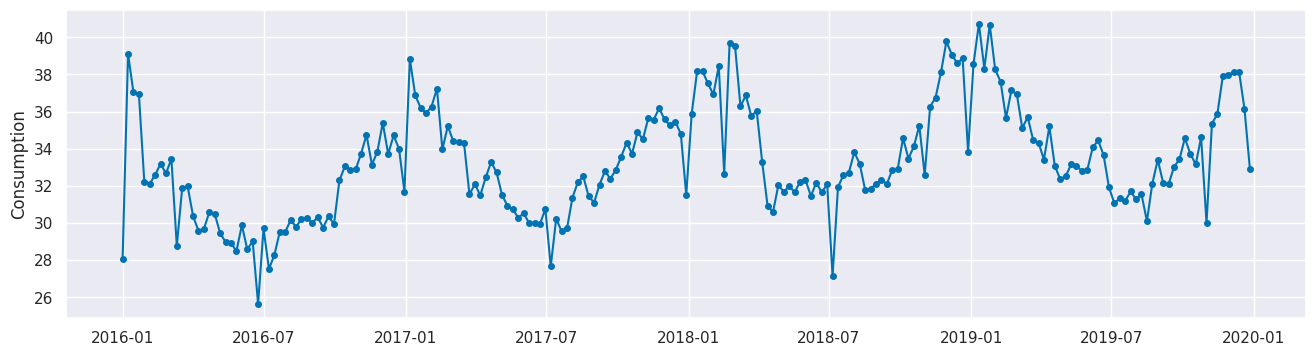

In [ ]:
# Визуализация полученых данных
#df['Consumption'].plot(linewidth=0.5);

# Визуализация полученых данных при помощи встроенных утилит
sktime.utils.plotting.plot_series(y);

На графике заметна сезонность. Это логично, пик потребления приходится на зиму, в отопительные периоды, а в летние месяцы расходовать электроэнергию на отопление не нужно. Похоже, что ряд нестационарен. Это мы проверим программным способом в дальнейшем анализе.

# Предсказание временных рядов

Для разделения данных на обучающую и тестовую выборки воспользуемся функцией temporal_train_test_split, которя позволяет адаптировать разделение данных не разрушая временные зависимости в данных.

Check splitted data size: Train: 115, Test: 94


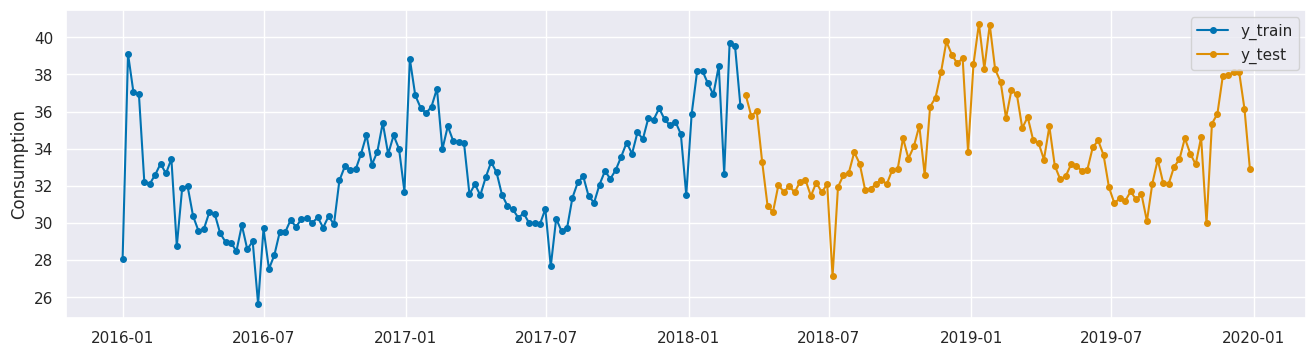

In [ ]:
TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

Помимо разделения данных на тренировочные и тестовые, предсказание в `sktime` может потребовать т.н. `forecasting horizon` - то есть непосредственного указания числа предсказываемых значений. Такой горизонт предсказания можно задавать по разному, при помощи массива или объекта класса `ForecastingHorizon`. Последний способ предоставляет более развитый инструментарий.

In [ ]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Экспоненциальное сглаживание

## Simple Exponential Smoothing

Авторегрессию в данном практическом задании мы не рассматриваем и сразу переходим к более продвинутым вариантам предсказателей - Семейству методов на основе экспоненциального сглаживания   (`Exponential Smoothing`, `Holt-Winter`). Давайте посмотрим на их работу. Для начала оценим точность наиболее простого варианта `Simple Exponential Smoothing`.

sMAPE = 0.108


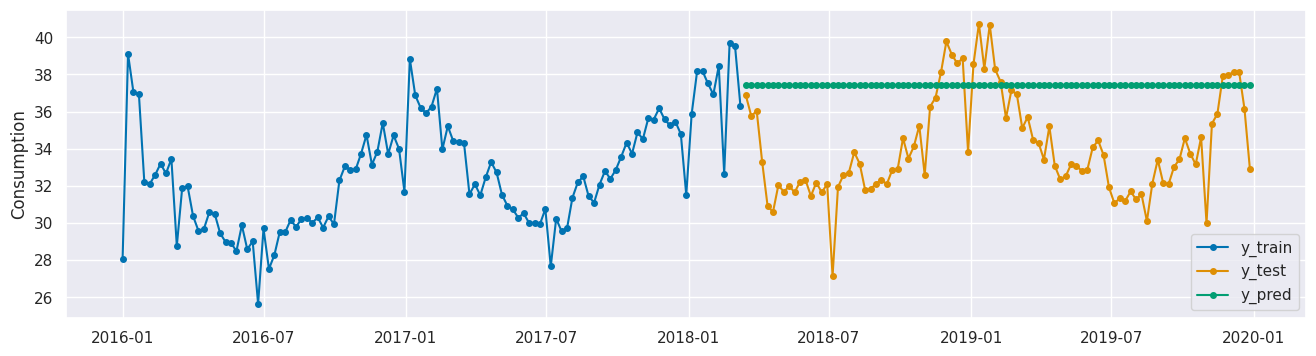

In [ ]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Точность такого метода оставляет желать лучшего. Посмотрим на работу более сложных методов экспоненциального сглаживания.

sMAPE = 0.053


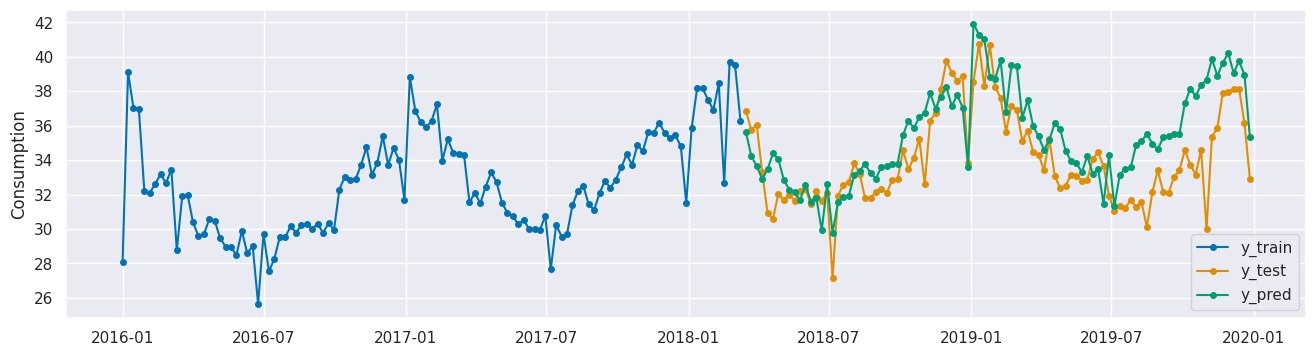

In [ ]:
SEASON = 52  # 7 дней в неделе * 52 недели = 365 дней (год)

# МЕТОДЫ
ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)

# ПРЕДСКАЗАТЕЛЬ
forecaster = EnsembleForecaster(
    [
#        ("ses", ses),
#         ("holt", holt),
#         ("damped", damped_holt),
        ("holt-winter",holt_winter),
#         ("holt-winter, additive trend, box-cox", holt_winter_add_boxcox),
        ("holt-winter, multiplicative trend, box-cox", holt_winter_mul_boxcox),
#         ("holt-winter, multiplicative season, box-cox", holt_winter_sadd_boxcox),
#         ("holt-winter, multiplicative both,   box-cox", holt_winter_smul_boxcox)
    ]
)
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# РЕЗУЛЬТАТ
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

В общем случае пакет `sktime` позволяет использовать автоматизированный подбор параметров модели экспоненциального сглаживания. Для этого может быть использован пакет `AutoETS`. Модель, реализуемая данным пакетом также называется `Error-Trend-Season (ETS)`. В случае необходимости исследоватлеь может вручную задать параметры моделе, в формате ETS(X,X,X)s</b>, где <b>X может быть N-None, A-additive, M-multiplicative, Ad-additive dumped, s-период сезона или None</b>.

Частными примерами модели ETS являются:
* Simple Exponential smoothing ETS(A,N,N).  
* Triple Exponential smoothing ETS(A,A,A).
* и многие другие.

sMAPE = 0.053


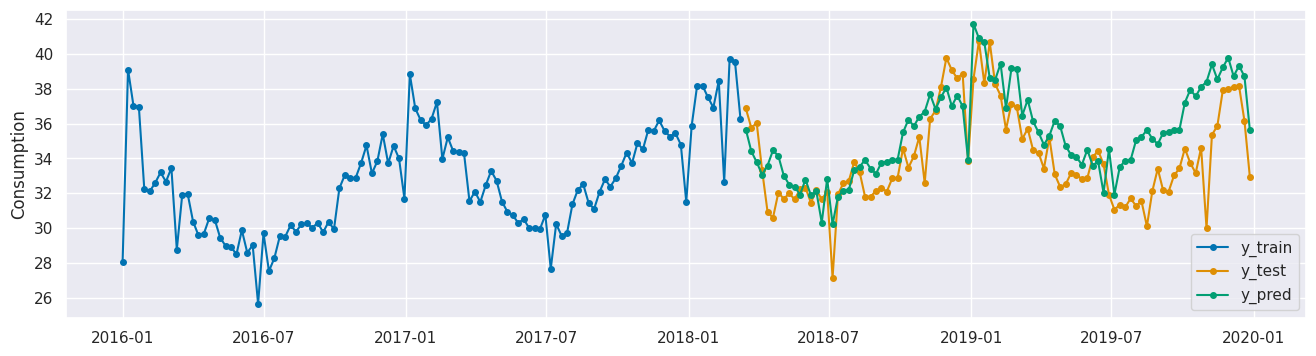

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Здесь мы видим, что ранее подобранные нами параметры оказались оптимальными.

## Метод с предварительной декомпозицией временного ряда

Другим методом оценки данных с вилянием сезонности и тренда является использование предварительной декомпозиции временного ряда. Одним из наиболее простых методов декомпозиции явялется разделение на тренд, сезонность и остаток. Давайте посмотрим на то, как будут выглядеть результаты такого разложения.

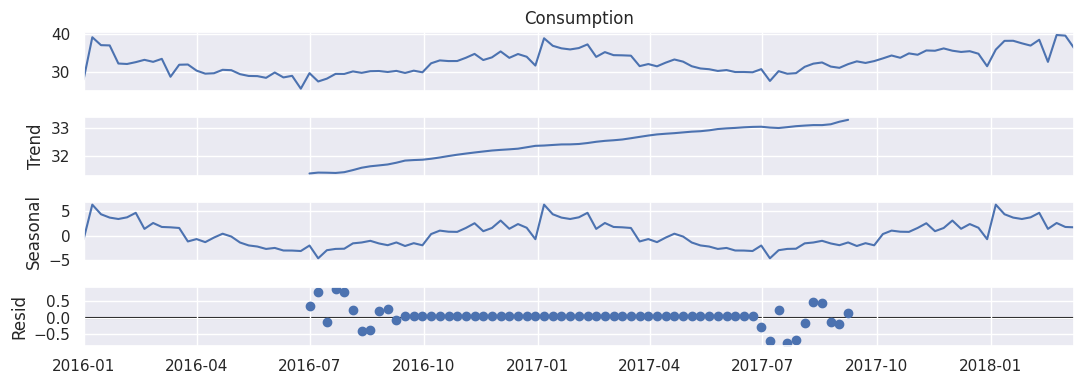

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(y_train, model='additive', period = 52)
result.plot();

В рамках пакета SKTime разложение можно выполнить при помощи объектов класса Deseasonalizer и Detrender.

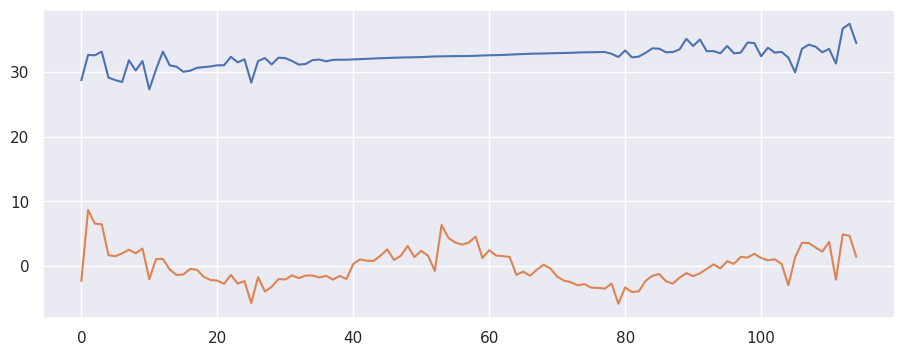

In [ ]:
deseason = Deseasonalizer(model="multiplicative", sp=52)
detrend  = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
plt.plot(deseason.fit_transform(y_train.values))
plt.plot(detrend.fit_transform(y_train.values))

Посмотрим на работу наиболее простого экспоненциального сглаживания с использованием разложения. Для этого будем использовать контейнер TransformedTargetForecaster - который явлется некоторым аналогом пайплайна.

sMAPE = 0.037


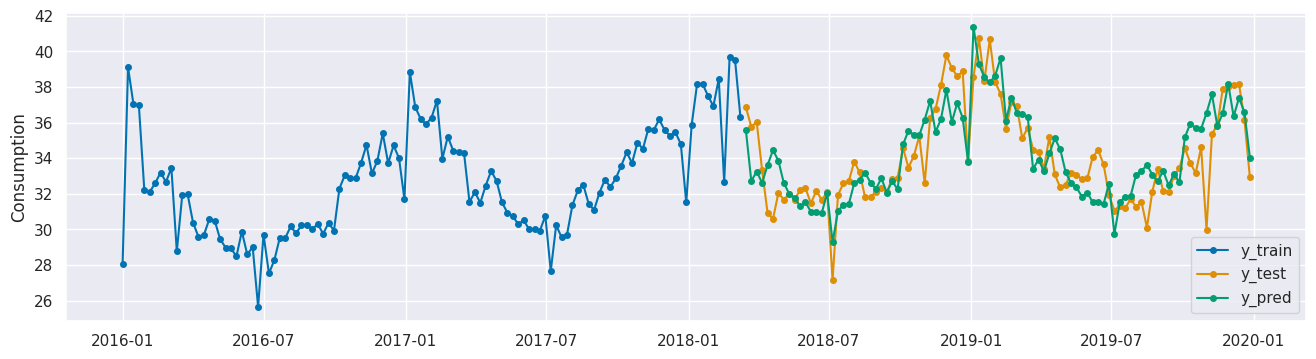

In [ ]:
SEASON = 52

fh = ForecastingHorizon(y_test.index, is_relative=False)

# объек предсказатель
ses         = ExponentialSmoothing()

# пайплайн
forecaster = TransformedTargetForecaster(
                steps=[
                ("deseasonalize", Deseasonalizer(model="multiplicative", sp=SEASON)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
                ("forecaster", ses)
                ])
forecaster.fit(y_train)

# Предсказание
y_pred = forecaster.predict(fh)

# Результаты
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

После декомпозиции мы получили результаты в прогнозировании схожие с экспоненциальным сглаживанием без декомпозиции данных. Возможно, что это особенность именно этого датасета.

## Использование пакета Scikit-learn для предсказаний

В качестве примера рассмотрим регрессию ближайших соседей.

sMAPE = 0.077


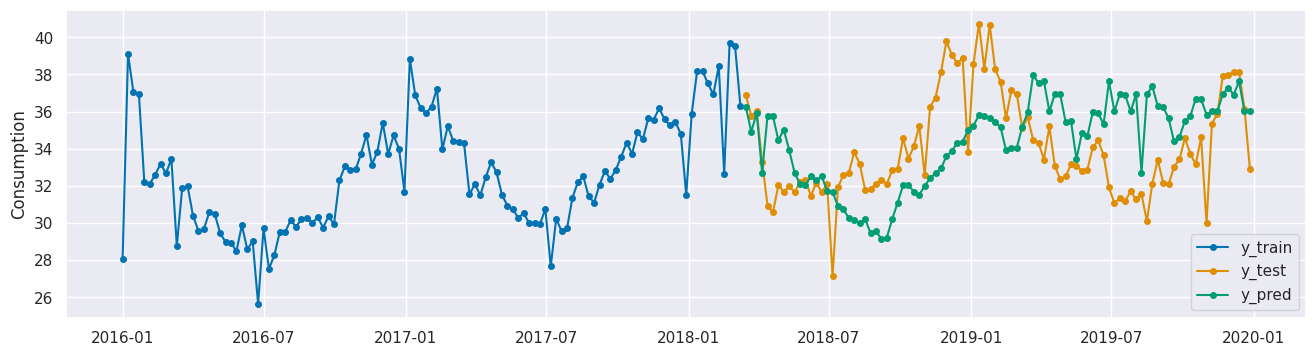

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 15

regressor  = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Современный метод регресии Prophet представленный в пакете SKTime

Prophet - метод предсказания временных рядов на основе т.н. обобщенной регресии для модели бизнесс процессов, которая включает тренд с точками перегиба и насыщением, несколько компонент сезонности и редкие но регулярные события (типа выходных дней).

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdcyg3vax/8m5zzknc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdcyg3vax/6p71wwpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46880', 'data', 'file=/tmp/tmpdcyg3vax/8m5zzknc.json', 'init=/tmp/tmpdcyg3vax/6p71wwpn.json', 'output', 'file=/tmp/tmpdcyg3vax/prophet_modelgacivp1n/prophet_model-20241022215541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:55:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


sMAPE = 0.048


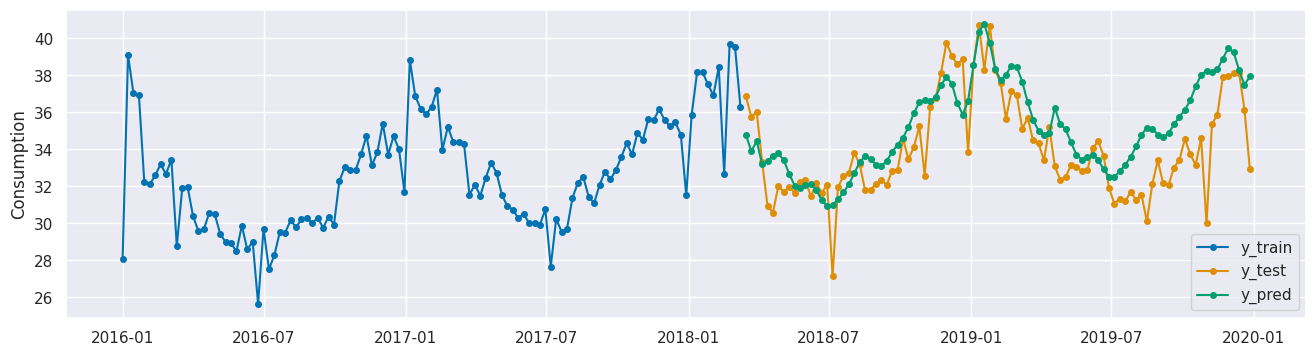

In [ ]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 4),
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

## Выводы по разделу Предсказания временных рядов


Были протестированы следующие методы:


1. Экспоненциальное сглаживание;  
2. Метод с предварительной декомпозицией временного ряда;
3. K-ближайших соседей из библиотеки sklearn;
4. Prophet из библиотеки sktime.

Как мне кажется, метод с декомпозицией временного ряда дал наилучшие предсказания. Метод К-ближайших соседей дал занижение предсказаний на первой половине тестовых данных, а на второй половине завышение. Метод Prohet хорошо сгладил ряд, но по пикам данных, т.е. можно сказать, что это он дает несколько завышенные оценки. Экспоненциальное сглаживание дает завышенные оценки, но к тому же еще и не достаточно сглаживает ряд, как это делает метод Prohet.

# Модели авторегрессии-скользящего среднего

# Анализ полученного однопеременного ряда

Для модели `AutoregRessive Integrated Moving Average` (`ARIMA`) существует три  параметра (порядка) (`p, d, q`):
* `p` - **авторегрессивная часть модели**. Этот параметр позволяет учесть влияние прошлых значений на текущее для модели. Прошлые значения здесь называются запаздывающими наблюдениями (также известными как «запаздывание» или «лаг»). Интуитивно это похоже на утверждение, что завтра, вероятно, будет тепло, если в последние 3 дня было тепло. Другими словами, здесь мы можем сказать, что текущее значение температуры зависит от последних трех значений.

* `d` – **интегрирование модели**. Этот параметр включает в себя степень различия лагов (то есть количество прошлых временных точек, которые нужно вычесть из текущего значения), чтобы сделать временной ряд стационарным (чтобы исключить часть тренда). Интуитивно это было бы похоже на утверждение о том, что, вероятно, будет одно и то же повышение температуры каждый день (или одно и то же ускорение для второй производной и т.д.).

* `q` - **скользящая средняя часть модели**. Этот параметр позволяет представить остаточную часть (шум, ошибку) модели как линейную комбинацию остаточных значений, наблюдаемых в предыдущие моменты времени.

Если в модели видно достаточно сильное влияние сезонной составляющей, то следует перейти к модели `ARIMA` с сезонными эффектами (`Seasonal ARIMA - SARIMA`).  Как правило такая модель обозначается как
$$SARIMA (p, d, q) (P, D, Q) s.$$
Где
* (`p, d, q`) -  несезонные параметрами, описанными выше;
* (`P, D, Q`) - сезеонные порядки, которые следуют тому же порядку определений как и описанныевыше, но применяются к сезонной составляющей временного ряда;
* `s` - это периодичность временного ряда (например, 4 для квартальных периодов, 12 для годовых периодов и т.д.).

Рассмотрим процедуру ручного выбора порядков модели. Как правило, начинать следует с дифференцирования для достижения стационарности. Как правило, это `1-3` порядок, реже - больше.

Правильный порядок дифференцирования (`d, D`) это порядок разности, который делает временной ряд шумоподобным
т.е. значения колеблется около четко определенного среднего и имеют почти постоянный разброс значений. При этом рекомендуется использовать сезонную производную только в случае сильного сезонного влияния.

## Импорт необходимых библиотек и модулей

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

In [ ]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)
r2_score = lambda y_pred, y_test: 1-np.sum(np.square(y_pred - y_test))/np.sum(np.square(y_test - np.mean(y_test)))

## Проверка временного ряда на стационарность

Для проверки стационарности после дифференцирования можно ипользовать несколько методов, в том числе:
* **Скользящая статистика**: построение скользящего среднего и скользящего стандартного отклонения. Идея этого метода в том, что временные ряды являются стационарными, если они остаются неизменными во времени. Скользящая статистика визуально показывает стационарность среднего значения.
* **Статистические тесты, в т.ч. Расширенный тест Дики-Фуллера**: временной ряд считается стационарным, если
значение `p-value` низкое (в соответствии с нулевой гипотезой), а критические значения с доверительными интервалами `1%, 5%, 10%` максимально близки к табличному значению параметра `ADF` (такой параметр принято назвывать `статистика ADF`). Если тест `ADF` показывает, что статистика `ADF` далека от критических значений, а значение `p-value` превышает пороговое значение (например (0,05), то ряд  является нестационарным. В обратном случае ряд следует признать стационарным.

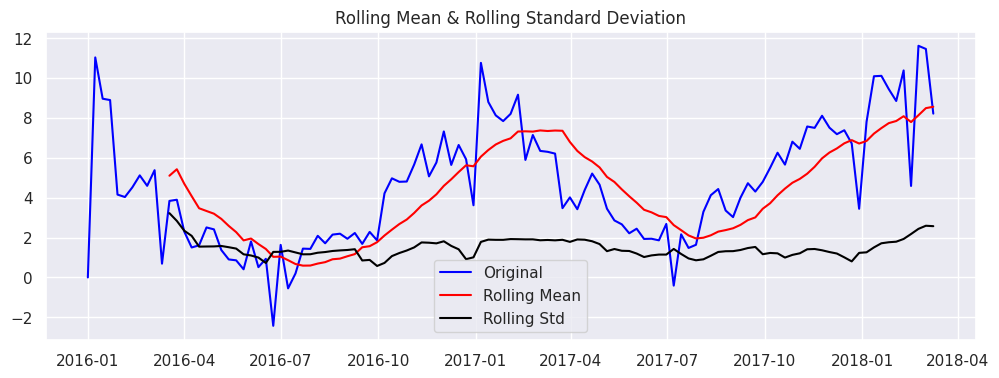

In [ ]:
rolling_mean = y_train.rolling(window = 12).mean()
rolling_std  = y_train.rolling(window = 12).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train-y_train[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Расширенный тест Дики-Фуллера для проверки стационарности временного ряда.

In [ ]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p-value: {:.8f}'.format(p_value))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value > p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -1.7646
p-value: 0.39816656
Critical Values:
	1%: -3.4901, outperformed
	5%: -2.8877, outperformed
	10%: -2.5807, outperformed
Result: The series is not stationary


Наиболее распространенной причиной нарушения стационарности является тенденция к среднему значению, которое может быть обусловлено либо наличием единого корня, либо детерминированного тренда.

Значение p-value выше уровня значимости, следовательно у нас нет оснований отклонить нулевую гипотезу о нестационарности ряда.
В нашем случае значение p-value значительно ниже уровня значимости 0,05, следовательно мы с достаточной степенью уверенности можем отклонить нулевую гипотезу и принять альтернативную о том, что ряд является не стационарным.

Для применения дальнейших методов необходимо преобразовать нестационарный ряд к стационарному. С этим может помочь Дифференциальный метод (Differencing).

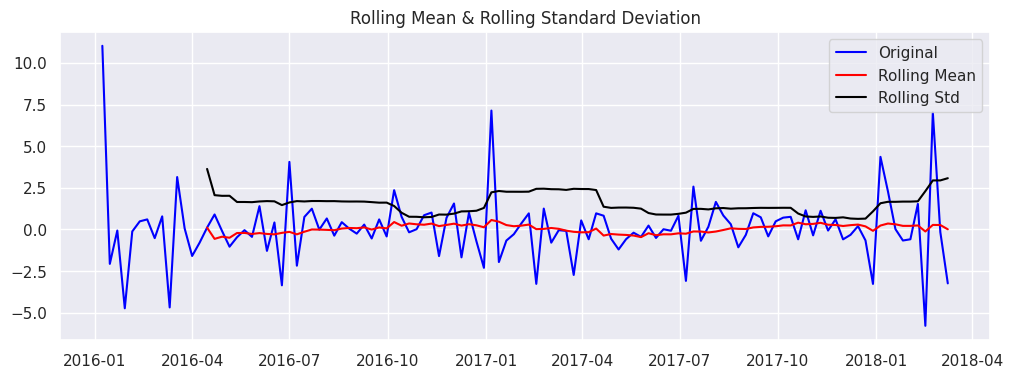

ADF Statistic: -11.3303
p-value: 0.00000000
Critical Values:
	1%: -3.4901, 
	5%: -2.8877, 
	10%: -2.5807, 
Result: The series is stationary


In [ ]:
y_diff = y_train[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Нам повезло: после первого пименения дифференциальной функции ряд стал стационарным. Так случается не всегда. В таких случаях производят данную операцию последовательно до приведения рада к стационарному. Однако избыточная дифференциация может привести к переобучению модели, поскольку она может акцентироваться на шуме, а не на значимых паттернах. Это создаст риск низкой обобщающей способности модели на новых данных.

Мы можем заключить что предварительной оценкой порядков дифференциации (интегрирования) являются: $d=1; D=1; s=52$.

## Рассмотрим графики ACF и PACF

При помощи графиков выберем оптимальные параметры авторегрессии-скользящего среднего.

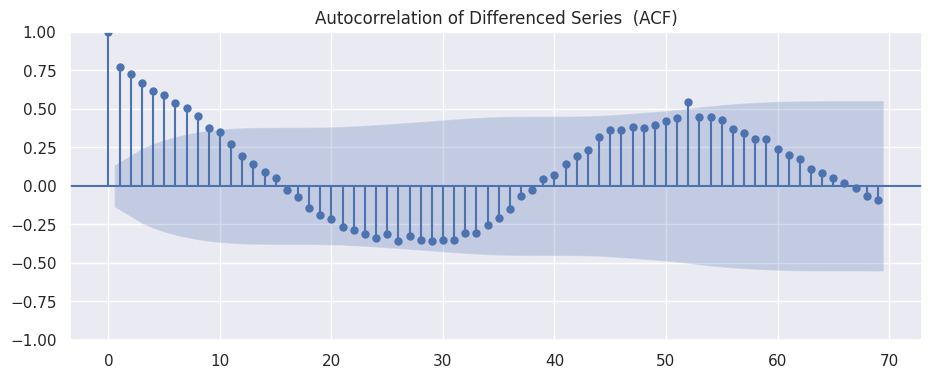

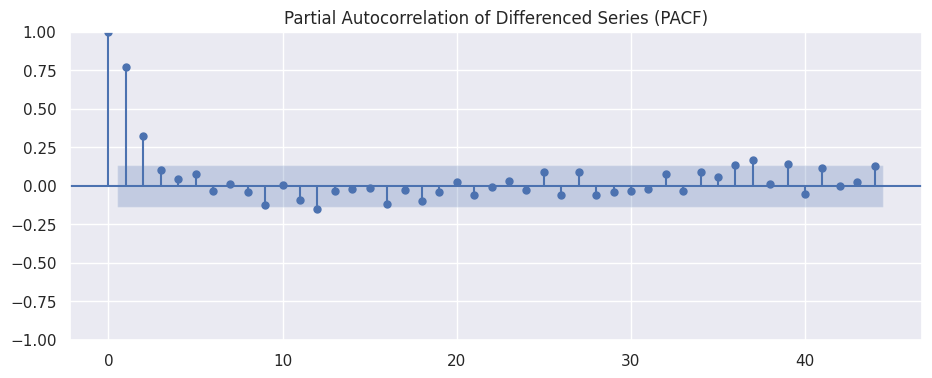

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y, title='Autocorrelation of Differenced Series  (ACF)', lags=np.arange(70) );plt.show()
# Usual Differencing
plot_pacf(y, title='Partial Autocorrelation of Differenced Series (PACF)', method='ywm', lags=np.arange(45));plt.show()

Из графиков выше следует следующий выбор параметров.
* Порядок q = 15 модели `MA`  (максимальный лаг, после которого значения ACF становятся незначительными или близкими к нулю);
* Порядок p = 5 модели  `AR`  (6 лаг `PACF` ниже нуля);
* К ряду один раз применялась дифференциальная функция, поэтому d = 1;


## Проверим модель SARMA

In [ ]:
forecaster = SARIMAX(order=(5, 1, 15), seasonal_order=(0, 1, 0, 52))
forecaster.fit(y_train)
print(forecaster.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  115
Model:             SARIMAX(5, 1, 15)x(0, 1, [], 52)   Log Likelihood                -101.565
Date:                              Tue, 22 Oct 2024   AIC                            247.129
Time:                                      21:56:26   BIC                            293.926
Sample:                                  01-01-2016   HQIC                           265.503
                                       - 03-09-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0624      0.107     -0.580      0.562      -0.273       0.148
ar.L1         -0.60

Выведенные результаты аппроксимации модели раскрывает достаточно много информации. В первой таблице представлена общая информация, включая критерии качества (`AIC, BIC` и `HQIC`). Таблица
посередине - это таблица коэффициентов, где значения столбца `coef` - это веса
соответствующих слогаемых. Значение `sigma2` – это `RSS` (средне квадратическая) ошибка модели. В последней
таблице представлены результаты различных статистических тестов для полученных остатков.

Помимо табличного представления, мы можем проводить диагностику остатков графическим способом. Напомним, что остатки в данном контексте означают разность модели, аппроксимированной при помощи `SARIMA` и тренеровочных данных.
Отметим, что данный способ не является стандартным методом класса `SARIMAX`, однако присуствует в нем.

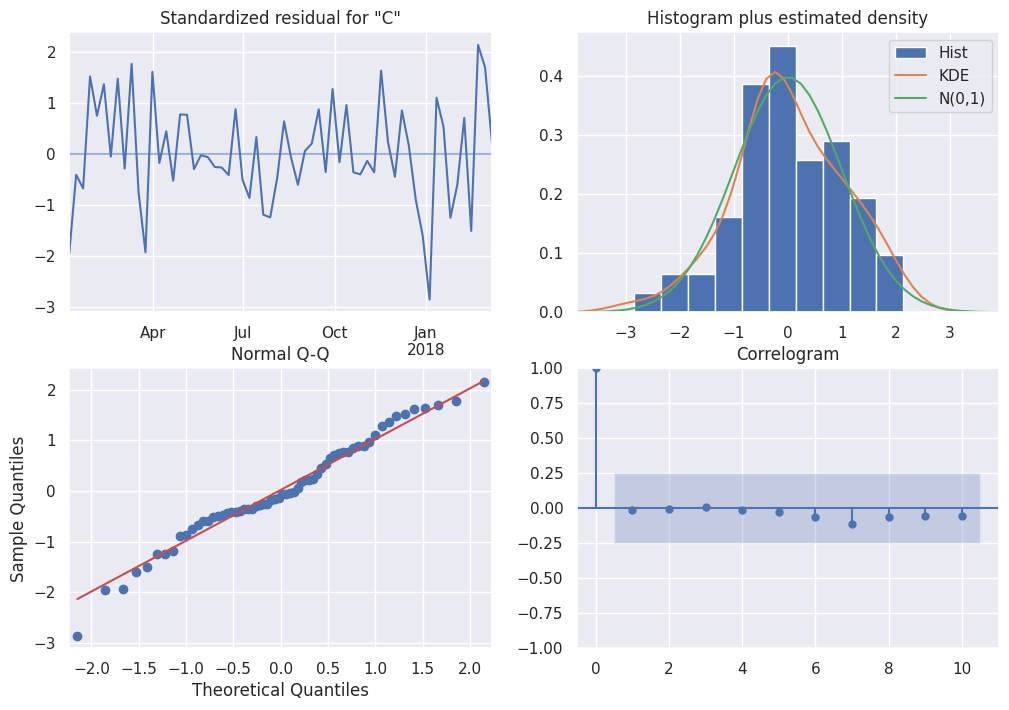

In [ ]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим:
* *верхний левый  график*: остаточные ошибки колеблются около нулевого среднего, однако имеют несколько неравномерную дисперсию, возможно модель недодифференцирована.
* *верхний правый график*: остаток имеет распределние, похожее на нормальное распределение.
* *нижний левый график*: график `Q-Q` показывает отклонения от нормального распределения.
* *нижний правый график*: автокорреляционная функция не показывает значительных (статистически значемых) отличий от нормального распределния.

Проведенный анализ показывает, что модель достаточна хороша, но можно попытаться её улучшить. При ручном поборе порядка модели следует отдавать предпочтения моделям с наименьшим значением критериев качества и с наименьшей ошибкой `RSS`.

В качестве первого предположения мы можем попытаться увеличить порядок дифференцирования модели.  После можно попробовать несколько значений разных порядков.

Теперь давайте попробуем визуализировать предсказания нашей модели.

sMAPE = 0.053


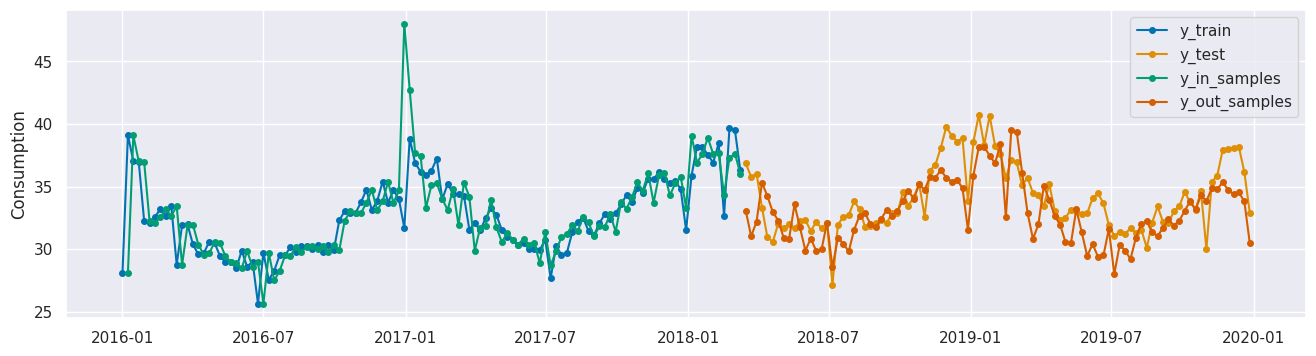

In [ ]:
# forecaster = SARIMAX(order=(5, 1, 15), seasonal_order=(2, 1, 0, 52))
# forecaster.fit(y_train)

fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Полученный результаты достаточно хорошо описывают модель, однако, рискнем предположить, что можно достичь и лучшей аппроксимации. Однако, также отметим что помимо полученных значений предсказаний важно и предсказание их дисперсии. Давайте попробуем построить такие интервалы.

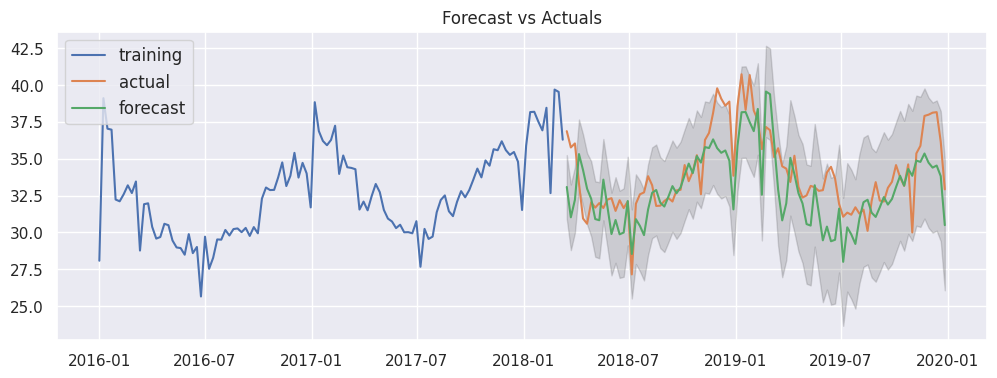

In [ ]:
# Forecast
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

forecast = forecast_res.predicted_mean

# Make as pandas series
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower Consumption'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper Consumption'], index=y_test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='training')
plt.plot(y_test,  label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [ ]:
model = AutoARIMA(start_p=2,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=5,  # начальный порядок MA
                  max_p=8,    # конечный порядок AR
                  max_q=20,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order = 29, # Максимальный порядок p+q+P+Q
                  trace  = True,   # отчет он-лайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',
                  suppress_warnings=True)

model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,5)(0,1,0)[52] intercept   : AIC=inf, Time=14.51 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=262.486, Time=0.29 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=259.103, Time=2.25 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=13.54 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=260.498, Time=0.40 sec
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=257.125, Time=0.35 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=259.103, Time=2.21 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=261.103, Time=2.82 sec
 ARIMA(2,1,0)(0,1,0)[52] intercept   : AIC=255.004, Time=0.63 sec
 ARIMA(2,1,0)(1,1,0)[52] intercept   : AIC=256.969, Time=11.48 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=256.969, Time=3.16 sec
 ARIMA(2,1,0)(1,1,1)[52] intercept   : AIC=258.969, Time=3.36 sec
 ARIMA(3,1,0)(0,1,0)[52] intercept   : AIC=246.400, Time=0.77 sec
 ARIMA(3,1,0)(1,1,0)[52] intercept   : AIC=248.392, Time=8.83 sec
 ARIMA(3,1,0)(0,1,1)[52] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(5, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -112.997
Date:                            Tue, 22 Oct 2024   AIC                            237.995
Time:                                    22:00:52   BIC                            250.758
Sample:                                01-01-2016   HQIC                           243.006
                                     - 03-09-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7205      0.116     -6.203      0.000      -0.948      -0.493
ar.L2         -0.7178      0.180     -3.988      0.000      -1.071      -0.365
ar.L3         -0.7713      0.155     -4.984      0.000      -1.075      -0.468
ar.L4         -0.5536      0.164     -3.384      0.001      -0.874      -0.233
ar.L5         -0.3004      0.171     -1.757      0.079      -0.636       0.035
sigma2         2.1731      0.427      5.093      0.000       1.337       3.009
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.78   Prob(JB):                         0.99
Heteroskedasticity (H):               1.16   Skew:                            -0.03
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

И так протестируем модель, выбранную автоматически.

sMAPE = 0.066


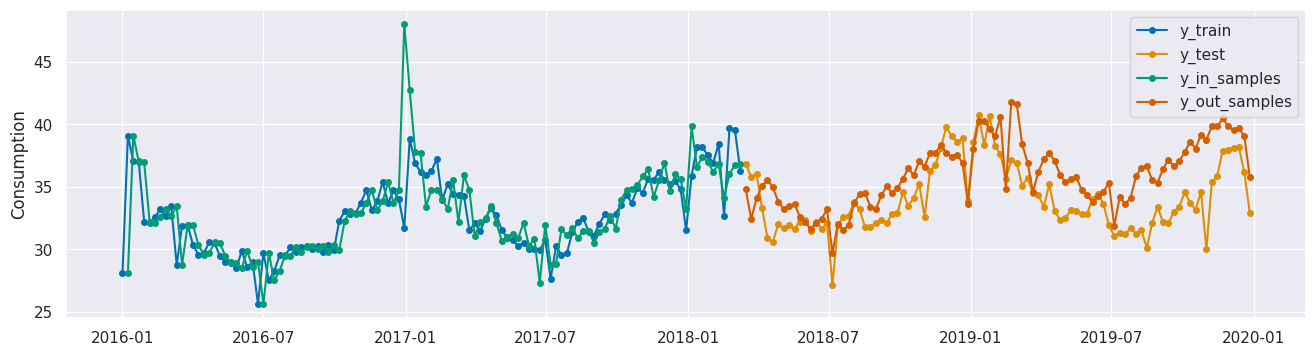

In [ ]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Полученная модель оказалась лучше найденной вручную. Однако, подчеркнем, что на практике такое не всегда бывает. В частности, можно заметить, что критерий AIC для модели, подобранной вручную был несколько ниже, чем для проверенных автоматически. Часто, автопоиск модели можно использовать лишь как некоторое очень хорошее начальной предположение.

Также отметим, что в рамках пакета SKTime доступны и другие методы работы с ARMA моделями. Например, вместо поиска производных можно провести предварительное удаление сезонности данных.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


sMAPE = 0.049


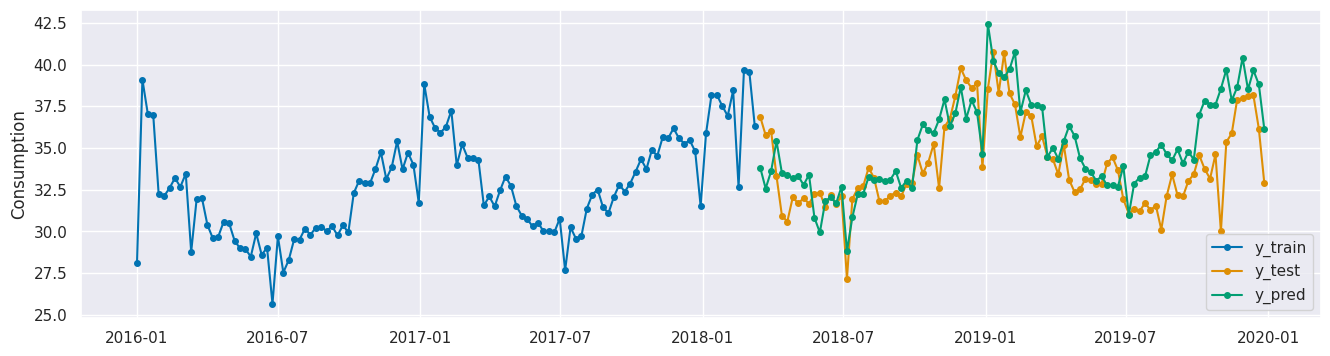

In [ ]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(5, 1, 15), seasonal_order=(0, 0, 0, 0),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Точность такого результата оказывается несколько ниже, однако, скорость обучения модели значительно увеличивается. В дополнение к этому такой подход позволяет проводить раздельно учитывать несколько сезонных составляющих в данных.


На сегодняшний день сеймейство моделей `ARIMA` является одним из основных методов предсказания временных рядов. Метод отлично подходит для однопеменных временных рядов. Метод хорошо работает как для рядов небольшой длительности, так и для достаточно длинных рядов. При этом метод подходит как для детерменированных, так и для случайных типо тренда. А также, само по себе описание ряда при помощи коэффициентов может быть важным признаком в ряде методов машинного обучения.

Также отметим, что часто метод `ARIMA` сравнивается c алгоритмом `Prophet`, который в свою очередь представляет собой некоторую адаптацию обобщенной регрессии к бизнесс процессом. Алгоритм `Prophet` в некоторых случаях может давать более точные предсказания, но не всегда.

## Выводы по моделям авторегрессии-скользящего среднего

На данном наборе получилось удачно подобрать параметры модели вручную. Графики ACF и PACF оказались весьма информативными. Автоматический подбор параметров AutoARIMA выдал худший результат, чем ручной выбор. Построенная модель SARIMAX на параметрах выбранных вручную показала лучший результат.

Если сравнивать модель ARIMA с алгоритмом Prophet, то последний показал гораздо лучшее хорошее сглаживание графика предсказаных значений. Визуально его предсказанные значения примерно совпадают с предсказаниями ARIMA.



# Классификация временных рядов

## Импорт необходимых библиотек

In [ ]:
from sklearn.model_selection import train_test_split

## Подготовка датасета

Сфомируем датасет с почасовыми данными. Датафрейм с этими данными у нас уже есть.

In [ ]:
df_hrly

,load_actual_entsoe_transparency,load_forecast_entsoe_transparency,solar_generation_actual,wind_onshore_generation_actual
utc_timestamp,,,,
2016-01-01 00:00:00+00:00,1094.00,1039.0,0.0,153.00
2016-01-01 01:00:00+00:00,1059.00,1003.0,0.0,138.00
2016-01-01 02:00:00+00:00,1034.00,980.0,0.0,126.00
2016-01-01 03:00:00+00:00,1029.00,981.0,0.0,126.00
2016-01-01 04:00:00+00:00,1050.00,971.0,0.0,131.00
...,...,...,...,...
2019-12-31 19:00:00+00:00,1332.26,1290.0,0.0,412.61
2019-12-31 20:00:00+00:00,1260.15,1222.0,0.0,326.54
2019-12-31 21:00:00+00:00,1191.67,1176.0,0.0,232.77


Уберем лишние колонки и зададим имена колонок, как нам нужно.

In [ ]:
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    #df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
    #df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

In [ ]:
cols_map = {'load_actual_entsoe_transparency' : 'Consumption' }   # Потребление
 #           'wind_onshore_generation_actual' : 'Wind',           # Генерация
 #           'solar_generation_actual' : 'Solar'}
df_hour = transform_dataframe(df_hrly, cols_map).dropna()

 Выгрузим полученный датасет в csv файл.

In [ ]:
df_hour.to_csv('lt_clf_data.csv')
df_hour.head()

,Consumption
Date,
2016-01-01 00:00:00+00:00,1.094
2016-01-01 01:00:00+00:00,1.059
2016-01-01 02:00:00+00:00,1.034
2016-01-01 03:00:00+00:00,1.029
2016-01-01 04:00:00+00:00,1.050


Если набор уже создан можно перейти к его открытию.

In [ ]:
df = pd.read_csv('lt_clf_data.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index.strftime('%Y-%m-%d-%H'))
df

,Consumption
Date,
2016-01-01 00:00:00,1.09400
2016-01-01 01:00:00,1.05900
2016-01-01 02:00:00,1.03400
2016-01-01 03:00:00,1.02900
2016-01-01 04:00:00,1.05000
...,...
2019-12-31 19:00:00,1.33226
2019-12-31 20:00:00,1.26015
2019-12-31 21:00:00,1.19167


In [ ]:
print(df.index.year)

Index([2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
       ...
       2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
      dtype='int32', name='Date', length=34947)


## Разбивка данных на месяцы и сезоны

Для текущей цели - изучить классификацию временных рядов давайте сделаем набор данных с классами. Для этого предлагается поставить задачу определение по дневному потреблению сезона (зима, весна, осень, лето):

Разделить все данные на 4 сезона (зима, весна, осень, лето)
взять данные с шагом 1 час.
создать сегменты размером 24 часа (1 день).

Для проведения классификации, как правило, данные следует разделять на сегменты. Как правило, эти сегменты не должны пересекаться. В нашем случае длина сегмента будет 24 точки.

Для цели создания набора данных давайте создадим 2 функции, первая split_by_month будет разделять наш набор данных на месяца. Вторая функция to_segments будет создавать сегменты по 24 часа в сутках.

In [ ]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = pd.concat([df_,df.loc[df.index.month == month]])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [ ]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(356, 24) (367, 24) (362, 24) (366, 24)


Теперь мы создали 4 класса. Давайте посмотрим как выглядят их примеры.

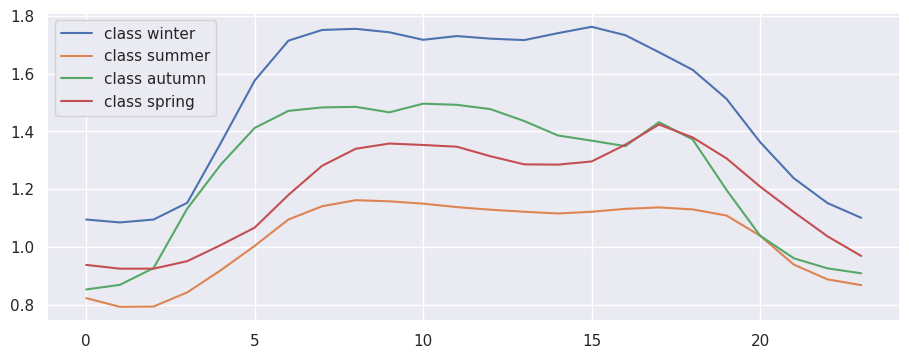

In [ ]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Хотя примеры показывают высокую степень сходства мы все же попробуем их классифицировать. Для этого создадим массив тренировочных и тестовых данных.

In [ ]:
X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1015, 24) (1015,) (436, 24) (436,)


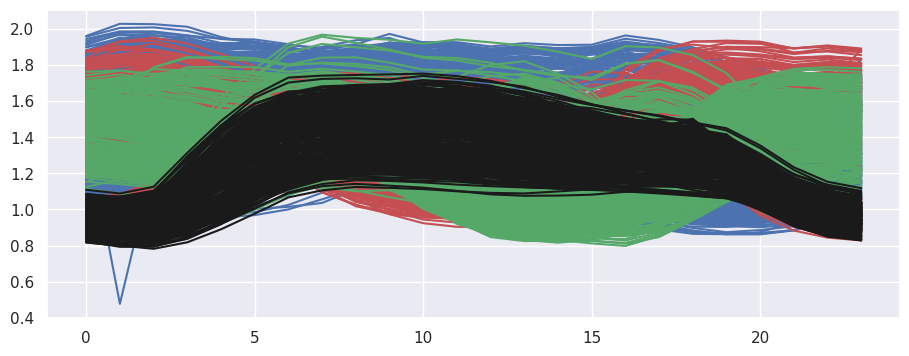

In [ ]:
[plt.plot(X[i], c= 'b') for i in range(len(X)) if y[i]==0];
[plt.plot(X[i], c= 'r') for i in range(len(X)) if y[i]==2];
[plt.plot(X[i], c= 'g') for i in range(len(X)) if y[i]==3];
[plt.plot(X[i], c= 'k') for i in range(len(X)) if y[i]==1];

Современная версия SKTime допускает формат массивов в виде 2d ndarray (numpy) для однопеременных временных рядов. Для многопеременных временных рядов массив может быть задан в виде 3d ndarray. В общем случае однопеменный ряд также может быть задан как многопеременный с размерностью массива
 Также в пакете SKTime предусмотрены и другие форматы. В том числе специализированные. Для преобразования между форматами используются convert и convert_to из модуля sktime.datatypes. Например, для преобразования двухмерного массива во встроенный однопеременных формат можно воспользоваться следующим скриптом

df = convert_to(np.atleast_3d(X).transpose(0,2,1), to_type="nested_univ")
Однако не все функции SKTime поддерживают 2d ndarray поэтому давайте создадим nested_univ копии данных.

In [ ]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ")
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ")

## Классификация sklearn

Перед тестированием специализированных методов из пакета SKTime давайте посмотрим на результаты стандартных подходов из sklearn. В анализе временных рядов среди таких стандартных подходов наиболее распространен случайный лес. Также давайте попробуем алгоритм k-соседей с евклидовым расстоянием как некоторую предварительную базовую оценку.

In [ ]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.963


In [ ]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d90451d0550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory


 test score 0.966


## Классификаторы ВР на основе данных

В пакете SKTime тип k-соседей алгоритмов находится в модуле distance_based.

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.933


Полученный результат не превзошёл результат с евклидовым расстоянием. Вероятно, это связано с близостью форм сегментов. Однако 1-NN DTW может быть реализован и в более продвинутых формах. Одной из таких форм является расстояние разностей ddtw.

Дополнительно укажем возможность использования матриц DTW и их модификаций в сторонних библиотеках, в том числе в качестве результатов ядерных преобразований (напр. в методе опорных векторов).

In [ ]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.977


Другим вариантом классификатора на основе данных являются Шейплет преобразования (и соответствующие им shapelet classifier). Напомним, что шейплет представляет собой участок временного ряда, обладающий наибольшей дискриминационной способностью для задачи. Другими словами, для участков - шейплетов различия между классами наиболее существенны.

Классификаторы на основе шейплетов позволяют найти наиболее различающиеся паттерны в данных.

В ракете SKTime шейплеты могут быть найдены в модуле sktime.classification.shapelet_based.

In [ ]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.984


## Подходы на основе т.н. словаря (Dictionary-based)

В пакете SKTime для работы со словарями используется модуль sktime.classification.dictionary_based.

In [ ]:
from sktime.classification.dictionary_based import (ContractableBOSS,
                                                    IndividualBOSS,
                                                    IndividualTDE,
                                                    MUSE, WEASEL)

Мы рассмотрим несколько методов на основе словарей:

метод BOSS один из наиболее популярных методов. Он основан на ансамблирование индивидуальных классификаторов BOSS (IndividualBOSS), использующих преобразование SFA. Классификатор выполняет сеточный поиск по большому числу параметров классификаторв. В итоге оставляют лишь те, для которых точность не ниже 92% от наилучшего. В качестве метода приниятия решний тут используется к-сосседей, но с оригальной функцией расстояния. Особенность тут в том, что SFA символы - это частотные представления сигнала. Таким образом итогом работы алагоритма становится представления символьного описания для набора частот. Мы воспользуемся тут лишь индивидуальным классификатором для того, чтобы не тратить на это много времени. Отметим, также что для оригинального алгоритма BOSS могут быть и другие модификации).

Среди модификаций BOSS мы рассмотрим вариант Temporal Dictionary Ensemble). Этот вариант включает Объеденение нескольких репрезентаций ВР, в т.ч. BOSS. Для экономии времени мы рассмотрим лишь одну из таких вариаций IndividualTDE.

MUSE (MUltivariate Symbolic Extension) (WEASLE-MUSE) также является расширением идеи SFA описания временонго ряда. В оригинальном WEASLE используются модификация SFA и метод контролируемого отбора признаков ANOVA. В упрощенной версии алгроитма - MUSE контролирумый отбор убран так как ведет с переобучению модели.

Отметим также особенность SFA симолов:

Значения в каждом окне нормируются так, чтобы стандартное отклонение было равно 1.

подсерия окна преобразуется с помощью быстрого преобразования Фурье, и сохраняются только первые несколько коэффициентов.

Каждый коэффициент дискретизируется в символ из алфавита фиксированного размера, образуя слово c использоованием специальной техники MCB.

In [ ]:
clf = IndividualBOSS(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9334862385321101

In [ ]:
clf = IndividualTDE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9334862385321101

In [ ]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9885321100917431

## Классификаторы на основе признаков

В пакете SKTime такие методы могут быть найдены в модуле sktime.classification.interval_based.

Мы рассмотрим несклько вариантов таких классификаторов. В некотором смысле все из рассматриваемых классификаторов этого типа относятся и к классификаторам на основе ансамблей деревьев. Однако тут такие ансамбли отличаются от классических алгоритмов. Среди методов интервальной классификации мы рассмотрим следующие:

Лес временных рядов (Time series forest, TSF). Алгоритм TSF) - это совокупность классифицирующих деревьев, построенных на основе сводных статистик случайно выбранных интервалов сегмента ВР. Для каждого дерева случайным образом выбираются sqrt(series_length) интервалов. Из каждого из этих интервалов извлекаются: среднее значение, стандартное отклонение и наклон линейного тренда. Значения объединяются в вектор признаков. Эти новые признаки затем используются для построения дерева, которое добавляется к ансамблю. В оригинальной работе также используется свой алгоритм разщипления деревьев.
RISE (Random Interval Spectral Ensemble)) - это ансамбль а основе деревьев. В отличие от TSF, он использует один интервал для каждого дерева и использует широкий набор спектральные характеристики в качестве вектора, а не сводную статистику. Изначально метод планировался для классификации аудиоданных. Имеются также и модификации модели.
SupervisedTimeSeriesForest как некоторый метод модификации временного леса), который включает контролируемый метод выбора интервалов, а также расширяет набор признаков.

In [ ]:
# from sktime.classification.interval_based import RSTSF
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based._rise import RandomIntervalSpectralEnsemble

In [ ]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.986


In [ ]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.991


In [ ]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.982


# Классификация временных рядов при помощи глубокого обучения

Одним из наиболее современных пакетов работы с временными рядами при помощи глубокого обучения нейронных сетей явялется пакет TSAI, официальная документация по данному пакету может быть найдена тут.

Пакет tsai — это пакет глубокого обучения с открытым исходным кодом, созданный на основе фреймворков Pytorch и fastai, ориентированный на современные методы для задач временных рядов, таких как классификация, регрессия, прогнозирование, вменение.

Для установки пакета разработчиками рекомендуется следующий скрипт:

In [ ]:
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 2.2.2 which is incompatible.


In [ ]:
# импорт пакета
from tsai.all import *
import warnings

computer_setup()

os              : Linux-6.1.85+-x86_64-with-glibc2.35
python          : 3.10.12
tsai            : 0.3.9
fastai          : 2.7.17
fastcore        : 1.7.19
torch           : 2.2.2+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn

Теперь давайте выбирем данные. Мы будем использовать тот же пример, что и для классификации в SKTime - набором данных открытые данные энергетических систем.

In [ ]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

Подготовим данные.

In [ ]:
X = np.concatenate((
                    winter,
                    summer,
                    autumn,
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

array([1, 1, 1, ..., 4, 4, 4])

Также давайте сопоставим названия классов и их номера для большего удобстсва.

In [ ]:
class_map = {
    1:'winter',
    2:'summer',
    3:'autumn',
    4:'spring',
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y)

Особенностью данного фреймворка (как и его основы fastai) является использование супер высокоуровневых API. Это длелает фреймворк tsai практически декларативным. Для проведения экспериментом нам потребуется лишь выбор модели и набора данных. Все обучение будет происходить в backend.

Для работы с наборами данных давайте создадим их разделение на тренировочную, валидационную и тестовую повыборки. Для этого воспользуемся функцией get_splits. В рамках урока мы задаим аргумент show_plot чтобы визуализировать разделение данных.

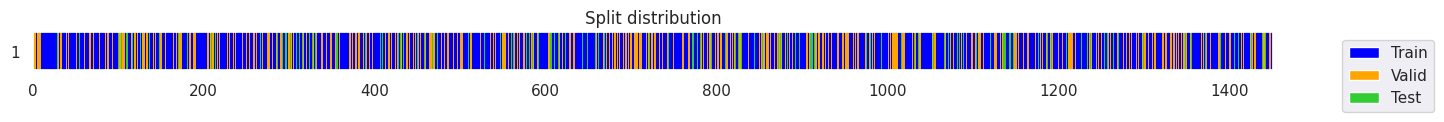

((#871) [399,1199,638,687,279,779,273,161,165,935...],
 (#435) [538,818,236,1441,1378,854,1009,1067,1181,78...],
 (#145) [810,50,116,1372,584,323,1299,327,892,912...])

In [ ]:
splits = get_splits(y,
                    n_splits=1,
                    valid_size=0.3,
                    test_size=0.1,
                    shuffle=True,
                    balance=False,
                    stratify=True,
                    random_state=42,
                    show_plot=True,
                    verbose=True)
splits

Для начала давайте созадим набор данных. Такой набор будет экземпляром класса TSDatasets. В наборе данных зададим разеделние данных и необходимые преобразования tfms.

Также сконфигурируем загручик батчей TSDataLoaders. Загрузим тренировочный и валидационный наборы данных.

In [ ]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

Среди анализируемых архитектур мы рассмотрим рекуррентные RNN, LSTM и GRU ячейки в двух вариантах обычном и плюс. Варианты несколько отличаются по архитектуре. Для обоих вариантов мы рассмотрим ахритектуры с 3 и 4 слоями, как двунаправленные, так и нет.

Кроме рекуррентных нейронных сетей мы также попробуем ряд стандартных сверточных архитектур, таких как ResNet1d, xresnet1d, InceptionTime, XceptionTime и TCN. Данные архитектуры представляют собой стандартные подходы к классификации временных рядов нейронными сетями. Последняя ахритектура представляет собой использование идеи расширенной свертки. архитектуры ResNet1d и xresnet1d отличиаются подходом к организации skipconnection. Архитектуры InceptionTime и XceptionTime представляют собой адаптированные под временные ряды соотвествующих сверточных сетей для изображений. Также, для сравнения, мы попробуем использовать смешанную архитектуру LSTM_FCN, полносвязную архитектуру FCN и архитектуру трансформер TST.

In [ ]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),
         (LSTM,    {'n_layers':3, 'bidirectional': False}),
         (RNN,     {'n_layers':3, 'bidirectional': True} ),
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),
         (ResNet, {}),
         (xresnet1d34, {}),
         (xresnet1d50_deeper, {}),
         (InceptionTime, {}),
         (XceptionTime,  {}),
         (TCN, {}),
         (LSTM_FCN, {}),
         (TST, {}),
         (FCN, {}),
        ]

Теперь попробуем запустить обучение. Для создания модели используем функцию create_model, которая для создает модель в формате совместимом с PyTorch для заданной архитектуры и набора гиперпараметров.

В пакете tsai обучение проводится для объекта класса Learner. Таким образом этот класс описывает модель (обученную архитектуру). Мы приведем лишь самую простую конфигурацию этого класса. Конфигурация включает указание загрузчика данных, модели и метрики. В качестве метрики мы используем точность (accuracy). Для запуска обучения в классе Learner используется метод fit_one_cycle. Для этого метода в качестве параметров мы зададим число эпох обучения и скорость обучения. Остальные параметры оставим по умолчению. Среди таких параметров будут функция потерь (кросс энтропия) и метод оптимизации ADAM.

По результатам обучения каждой модели мы занесем в таблицу полученные результаты, в том числе точность для валидационного набора данных и время обучения.

In [ ]:
from IPython.display import clear_output



results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):

    model = create_model(arch, dls=dls, **k)

    print(model.__class__.__name__)

    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478724,0.203096,0.121056,0.967816,39
1,RNN,"{'n_layers': 3, 'bidirectional': True}",142204,0.636014,0.250605,0.933333,15
2,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202604,0.609471,0.283944,0.928736,21
3,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142204,0.624875,0.340108,0.901149,15
4,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71304,0.733866,0.429009,0.891954,9
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",566404,1.116479,0.942699,0.664368,63
6,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566404,1.137461,0.984235,0.602299,66
7,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",425004,1.228528,1.098532,0.588506,40
8,GRU,"{'n_layers': 3, 'bidirectional': True}",425004,1.233532,1.099065,0.586207,40
9,LSTM,"{'n_layers': 3, 'bidirectional': False}",203204,1.212668,1.129446,0.498851,27


TypeError: Conv1d.__init__() got an unexpected keyword argument 'seq_len'

Среди полученных результатов хотелось бы выделить RNNPlus. Эта архитектура дала результат, оптимальный по соотношению точности и времени работы. Давайте рассмотрим эту архитектуру подробней

In [ ]:
arch = RNNPlus
k = {'n_layers': 4, 'bidirectional': True}
model = create_model(arch, dls=dls, **k)

In [ ]:
model = build_ts_model(RNNPlus, arch_config=k, dls=dls)

Фреймворк tsai предлагает метод определния оптимальной скорости обучения на основе тестовы нескольких эпох обучения. Попробуем определить лучшую скорость обучения.

SuggestedLRs(valley=0.00019054606673307717)

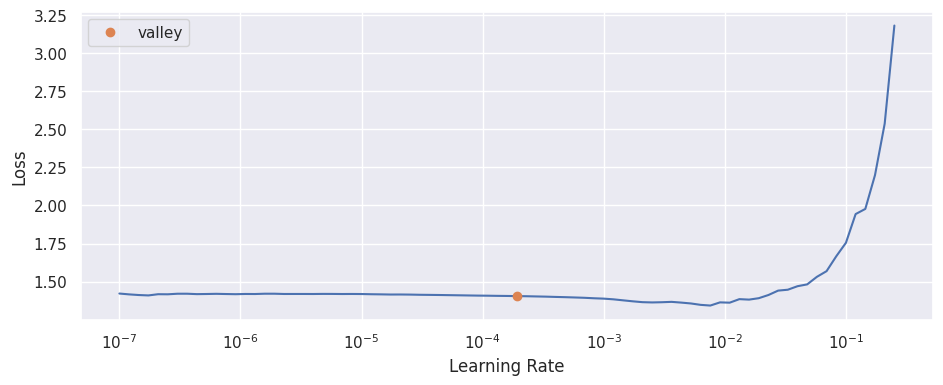

In [ ]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

Теперь снова запустим обучение. В этот раз мы запустим процедуру тренировки с коллбеком, позволяющим отслеживать значения функций потерь в режиме он-лайн.

epoch,train_loss,valid_loss,accuracy,time
0,1.421588,1.419670,0.248276,00:00
1,1.417362,1.416601,0.248276,00:00
2,1.415294,1.412933,0.248276,00:01
3,1.414026,1.408528,0.248276,00:01
4,1.411904,1.403610,0.137931,00:00
5,1.410003,1.398635,0.204598,00:00
6,1.407487,1.393940,0.255172,00:00
7,1.405282,1.389791,0.252874,00:01
8,1.402635,1.386131,0.252874,00:01
9,1.400374,1.383018,0.252874,00:01


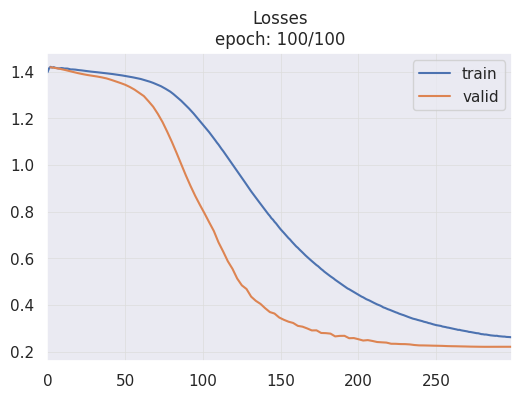

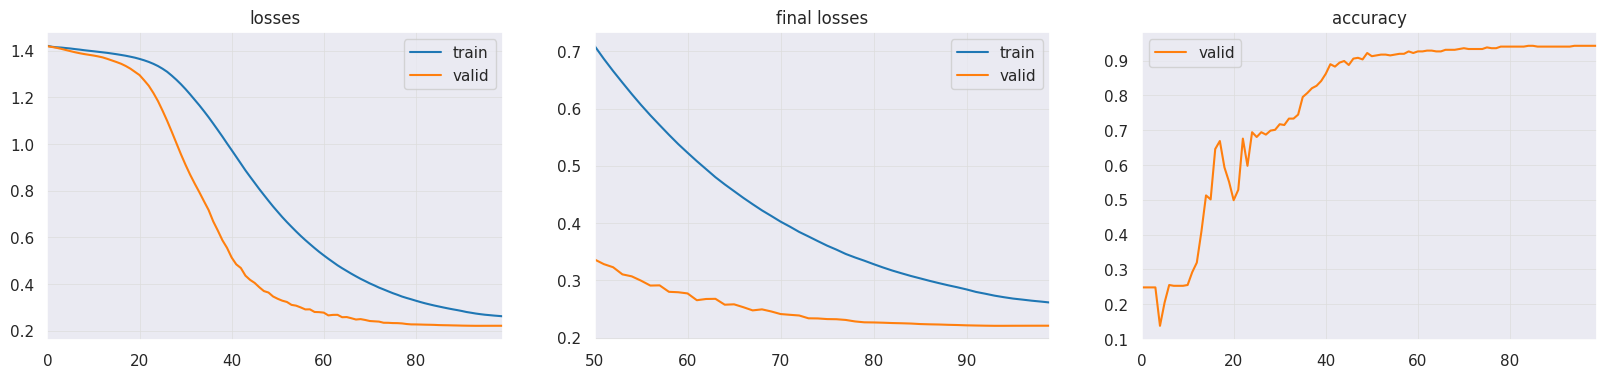

In [ ]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.00009, cbs=ShowGraph())

Рассмотрим несколько примеров результатов для валидационного набора данных.

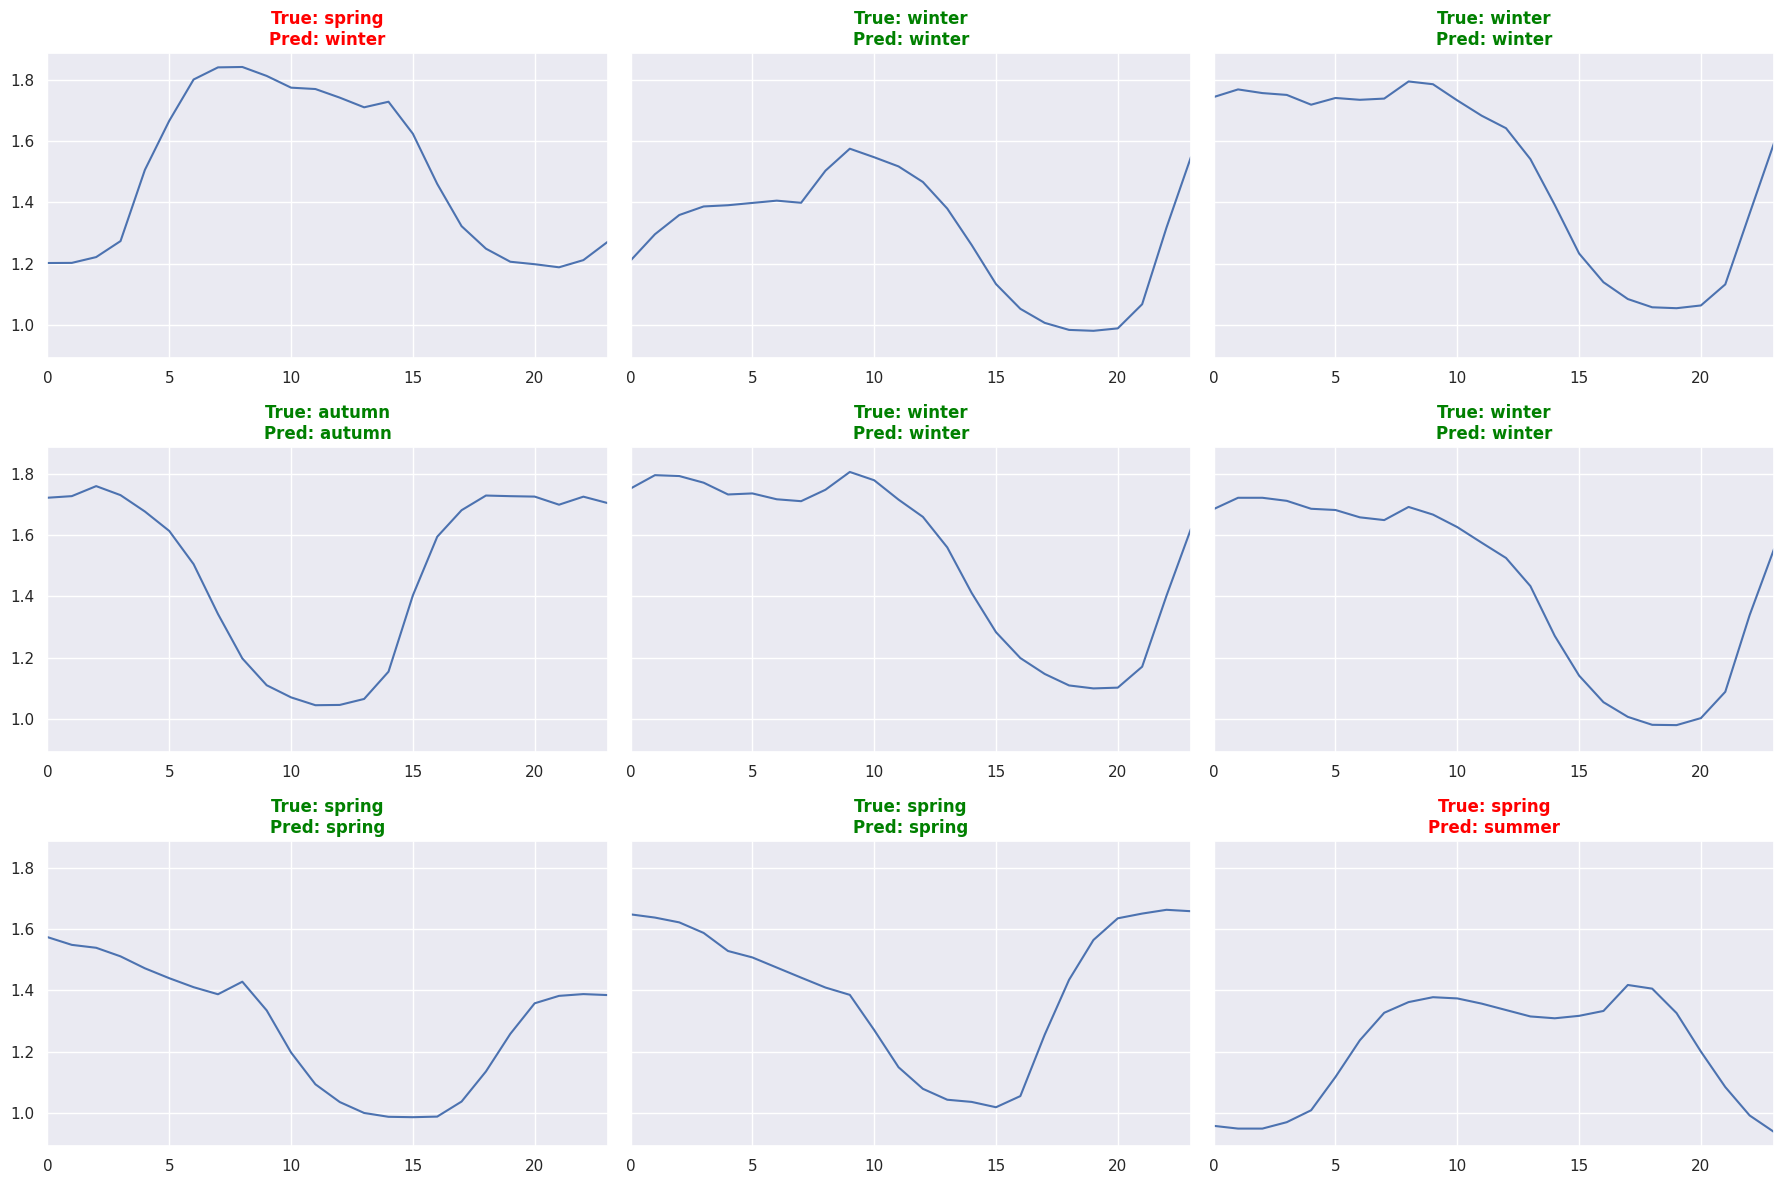

In [ ]:
learn.show_results(sharey=True)

Также давайте попробуем визуализировать результаты. Следующий график показывает вероятность при которой определяется класс для кажого семплта валидационной выборки.

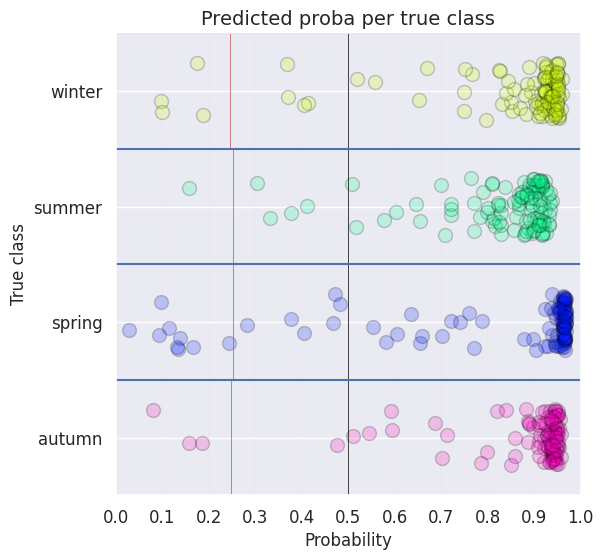

In [ ]:
learn.show_probas()

Также для анализа ошибок давайте посмотрим на матрицу ошибок.

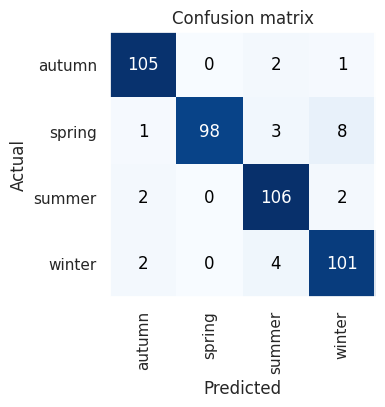

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Выбирем из матрицы наиболее ошибочные случаи.

In [ ]:
interp.most_confused(min_val=3)

[('spring', 'winter', 8), ('winter', 'summer', 4), ('spring', 'summer', 3)]

Помимо прочего поппробуем сделать предсказания для тестового набора данных.

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['autumn', 'summer', 'winter', 'spring', 'summer']",
 array(['autumn', 'winter', 'winter', 'spring', 'summer'], dtype='<U6'))

Оценим точность на тестовом наборе данных

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

In [ ]:
class_map = {
    'winter':3,
    'summer':2,
    'autumn':0,
    'spring':1,
    }
class_map

labeler = ReLabeler(class_map)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))

0.9379310344827586

# Сравние точности классических методов классификации и методов при помощи глубокого обучения

Сравнение точности классических методов классификации и методов глубокого обучения в контексте временных рядов или задач классификации может зависеть от множества факторов, включая характер данных, сложность задач и количество доступной информации для обучения модели.

##Методы глубокого обучения:##
1. MUSE - 0.988
2. TimeSeriesForestClassifier - 0.986
3. RandomIntervalSpectralEnsemble - 0.991
4. SupervisedTimeSeriesForest - 0.982

##Классические методы классификации:##
1. RandomForestClassifier - 0.963
2. KNeighborsClassifier - 0.966
3. KNeighborsTimeSeriesClassifier - 0.977
4. ShapeletTransformClassifier - 0.984
5. IndividualBOSS - 0.933
6. IndividualTDE - 0.933
7. Наименьшая ошибки моделей ARIMA составила 4,9%.
8. У модели Prothet ошибка составила 4,8%.

#Результаты и аналитика#
##Глубокое обучение:##


Наивысшую точность показывает метод RandomIntervalSpectralEnsemble с результатом 0.991, что делает его одним из самых эффективных решений.


Также высокие результаты у MUSE и TimeSeriesForestClassifier с точностями 0.988 и 0.986 соответственно, что говорит о том, что они способны эффективно справляться с различными задачами классификации временных рядов.


##Классические методы:##


RandomForestClassifier и KNeighborsClassifier показывают относительно высокие результаты, однако, они уступают по качеству методам глубокого обучения и специальным ансамблевым методам.
Несмотря на то, что ShapeletTransformClassifier показывает довольно высокий результат (0.984), он все же ниже, чем некоторые модели глубокого обучения.

Модели ARIMA могут выдать результат с достаточно невысокой ошибкой 5%, однако эта ошибки выше, чем при использовании других продвинутых методов.

##Рекомендации по выбору метода классификации:##

Если объем данных достаточный для обучения сложных моделей и ресурсы, чтобы запускать их, я бы рекомендовал использовать RandomIntervalSpectralEnsemble или MUSE. Эти методы показывают наивысшую точность и могут лучше учесть сложные паттерны в данных.

В случае ограничений по вычислительным ресурсам или меньшего объема данных можно рассмотреть использование ShapeletTransformClassifier или KNeighborsTimeSeriesClassifier, так как они показывают хорошие результаты без необходимости в обработке больших объемов данных, что упрощает процесс их обучения.


Также стоит обратить внимание на методы, использующие ансамбли (например, SupervisedTimeSeriesForest), поскольку они могут объединять силу нескольких моделей, повышая общую точность классификации.


#Заключение#
В зависимости от целей, характеристик данных и наличия ресурсов предлагается выбирать среди указанных методов, ориентируясь на их производительность и доступность. Исторически, методы глубокого обучения показывают лучшие результаты, но классические алгоритмы часто могут быть более легкими в реализации и интерпретации.